In [1]:
# !pip install highway-env
# !pip install git+https://github.com/DLR-RM/stable-baselines3
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb python-opengl ffmpeg
# !git clone https://github.com/eleurent/highway-env.git 2> /dev/null
# !git clone https://github.com/avivg7/highway-config.git
# !pip install tensorboard
# !pip install xvfbwrapper

In [1]:
# General
import sys
sys.path.insert(0, '/content/highway-env/scripts/')
import io
import base64
import os
from tqdm.notebook import trange
import numpy as np
import random
import math
import pygame
import json
import ast
from pprint import pprint 
import glob
from collections import Counter

# Local
from final_project.display_utils import wrap_env, show_video
from models.agent import Agent
from models.utils import plot_learning_curve

# Gym Env
import gym
import highway_env
# from utils import record_videos, show_videos
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Visualization
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay

%load_ext tensorboard
%matplotlib inline

pygame 2.1.2 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [3]:
# #=============== DO NOT DELETE ===============
# file = open('./highway-config/config_ex1.txt', 'r')
# contents = file.read()
# config1 = ast.literal_eval(contents)
# file.close()
# # ============================================

# env = gym.make("highway-fast-v0")
# env.configure(config1)

# obs = env.reset()
# for j in range(10):
#     obs, _, _, _ = env.step(0)

#     _, axes = plt.subplots(ncols=4, figsize=(12, 5))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
    

# env = wrap_env(env)
# env.reset()
# done = False
# iter = 0

# while (iter < 10) or not done:
#   if done:
#     break
#   iter +=1
#   action = env.action_space.sample()
#   observation, reward, done, _ = env.step(action)
#   screen = env.render(mode='rgb_array')
#   plt.imshow(screen)
#   print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

In [4]:
torch.cuda.is_available()

True

In [5]:
#=============== DO NOT DELETE ===============
# file = open('/content/highway-config/config_ex1.txt', 'r')
# contents = file.read()
# config1 = ast.literal_eval(contents)
# file.close()
# ============================================

file = open('./highway-config/config_ex1.txt', 'r')
contents = file.read()
# print(contents)
config1 = ast.literal_eval(contents)
file.close()

env = gym.make("highway-fast-v0")
env.configure(config1)
# env = wrap_env(env)
env.reset()
# env.config

ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[99., 99., 99., ..., 99., 99., 99.],
        [99., 99., 99., ..., 99., 99., 99.],
        [99., 99., 99., ..., 99., 99., 99.],
        ..

In [6]:
# a = np.max(observation)

# while a == 0:
#     action = env.action_space.sample()
#     observation, reward, done, _ = env.step(action)
#     a = np.max(observation)
# print(f'np.max(observation): {np.max(observation)}')
# print(f'np.min(observation): {np.min(observation)}')    
# for i in range(100):
#     action = env.action_space.sample()
#     observation, reward, done, _ = env.step(action)

#     pprint(action)
# # pprint(observation)
#     print(f'np.max(observation): {np.max(observation)}')
#     print(f'np.min(observation): {np.min(observation)}')

In [7]:
env.observation_space.shape

(4, 128, 128)

(10000, 4, 128, 128)
4 128 128


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 0, Score 20.754216478583764, Average Score: 20.754216478583764
Episode: 1, Score 9.685763418659178, Average Score: 15.219989948621471


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 2, Score 5.483398255859466, Average Score: 11.974459384367469


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 3, Score 32.971739954920416, Average Score: 17.223779527005703


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 4, Score 6.092317143883674, Average Score: 14.997487050381299


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 5, Score 13.105100877420613, Average Score: 14.68208935488785


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 6, Score 6.680116523197912, Average Score: 13.538950378932144


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 7, Score 42.98128664356579, Average Score: 17.21924241201135


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 8, Score 6.2496510950968585, Average Score: 16.000398932354184


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 9, Score 32.532472040540064, Average Score: 17.65360624317277


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 10, Score 4.786974154535018, Average Score: 16.483912416932977


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 11, Score 7.3882125601838915, Average Score: 15.725937428870552


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 12, Score 9.87095365242165, Average Score: 15.275554061451405


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 13, Score 10.646876884096914, Average Score: 14.944934263068943


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 14, Score 4.884379084817486, Average Score: 14.274230584518845


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 15, Score 5.201505354333669, Average Score: 13.707185257632272


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 16, Score 7.708139618432594, Average Score: 13.354300220032291


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 17, Score 12.50788835183821, Average Score: 13.307277338465953


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 18, Score 15.792195770677878, Average Score: 13.438062519108685


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 19, Score 6.772750411448514, Average Score: 13.104796913725675


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 20, Score 10.87177851498934, Average Score: 12.99846270426204


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 21, Score 15.545114319101005, Average Score: 13.11421959584563


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 22, Score 12.21753140812314, Average Score: 13.075233152901173


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 23, Score 17.501429759945555, Average Score: 13.259658011528026


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 24, Score 4.683406179661155, Average Score: 12.916607938253353


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 25, Score 21.358730155771777, Average Score: 13.241304946619445


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 26, Score 10.454855148167404, Average Score: 13.138103102232332


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 27, Score 24.631370434210794, Average Score: 13.548576935517277


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 28, Score 8.8400791746122, Average Score: 13.38621494376193


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 29, Score 8.68673645397624, Average Score: 13.229565660769074


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 30, Score 6.633811187302675, Average Score: 13.016799387431448


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 31, Score 26.640251513716606, Average Score: 13.442532266377858


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 32, Score 37.744227192879876, Average Score: 14.178947264150647


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 33, Score 4.016855849190611, Average Score: 13.880062222534175


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 34, Score 8.225197978487058, Average Score: 13.718494672704258


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 35, Score 9.39855202169896, Average Score: 13.598496265731889


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 36, Score 7.380639242431986, Average Score: 13.430446075912972


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 37, Score 8.576583963102642, Average Score: 13.302712862417962


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 38, Score 6.126715515752825, Average Score: 13.11871293045219


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 39, Score 14.64490337588536, Average Score: 13.156867691588019


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 40, Score 6.712651062775015, Average Score: 12.999691676251116


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 41, Score 8.629689569054849, Average Score: 12.895644007032157


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 42, Score 7.214822721155789, Average Score: 12.7635318841048


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 43, Score 23.4294357809, Average Score: 13.005938790850145


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 44, Score 4.618506094069232, Average Score: 12.819551397588349


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 45, Score 13.813465226314493, Average Score: 12.84115821995196


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 46, Score 4.6934130569640224, Average Score: 12.667801939888388


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 47, Score 16.893658056130434, Average Score: 12.755840608976763


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 48, Score 7.073397174832891, Average Score: 12.639872375626888


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 49, Score 6.560365385321683, Average Score: 12.518282235820784


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 50, Score 11.765742927733644, Average Score: 12.503526563113192


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 51, Score 11.058187044338997, Average Score: 12.475731572367534


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 52, Score 18.313634692476032, Average Score: 12.58588068784128


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 53, Score 17.136512322512118, Average Score: 12.670151644038889


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 54, Score 12.812103581583358, Average Score: 12.672732588357878


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 55, Score 7.306685743698484, Average Score: 12.576910323274676


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 56, Score 13.386299285896932, Average Score: 12.591110129636471


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 57, Score 12.757654507911333, Average Score: 12.593981584434312


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 58, Score 11.147554751246012, Average Score: 12.569465875397222


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 59, Score 6.6147248407138335, Average Score: 12.470220191485833


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 60, Score 12.965212570434351, Average Score: 12.478334820648923


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 61, Score 8.059903224937692, Average Score: 12.407069794911646


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 62, Score 15.873184492575003, Average Score: 12.462087488525349


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 63, Score 17.192710572946677, Average Score: 12.53600347421943


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 64, Score 10.663726556058315, Average Score: 12.50719921394003


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 65, Score 10.815251674180095, Average Score: 12.481563645155788


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 66, Score 10.050534367683058, Average Score: 12.445279626089032


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 67, Score 6.792088852714291, Average Score: 12.36214446765705


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 68, Score 9.55957975463444, Average Score: 12.321527587758172


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 69, Score 26.350227921773136, Average Score: 12.521937592529815


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 70, Score 27.18055661798705, Average Score: 12.728397015423578


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 71, Score 18.55419207444042, Average Score: 12.809310835687702


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 72, Score 16.11323217918065, Average Score: 12.854570032173905


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 73, Score 5.690611687650222, Average Score: 12.757759784274937


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 74, Score 6.08188133834475, Average Score: 12.668748071662533


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 75, Score 13.489723210515317, Average Score: 12.679550376121123


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 76, Score 8.594570093479872, Average Score: 12.626498684138769


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 77, Score 17.07786339501397, Average Score: 12.683567462483323


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 78, Score 30.72608404165658, Average Score: 12.911953748295643


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 79, Score 6.028901371008615, Average Score: 12.825915593579555


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 80, Score 7.073397174832891, Average Score: 12.754896847669103


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 81, Score 8.360397756539667, Average Score: 12.701305395338256


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 82, Score 8.213354824464636, Average Score: 12.647233701713272


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 83, Score 11.391088732526567, Average Score: 12.632279594937241


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 84, Score 18.74092300216805, Average Score: 12.704145987963487


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 85, Score 9.085440297732639, Average Score: 12.66206801482127


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 86, Score 12.125277775916096, Average Score: 12.655898012075234


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 87, Score 16.24233618450811, Average Score: 12.696652991307422


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 88, Score 7.966800735763556, Average Score: 12.643508583941761


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 89, Score 17.904778392534805, Average Score: 12.701967137370573


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 90, Score 8.805827158783416, Average Score: 12.659152412331153


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 91, Score 6.34253312233663, Average Score: 12.590493507005124


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 92, Score 15.700451657832467, Average Score: 12.623933917229074


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 93, Score 19.635663552384983, Average Score: 12.69852678568818


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 94, Score 18.26887564645173, Average Score: 12.757162036854114


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 95, Score 5.580775896473005, Average Score: 12.682408014558476


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 96, Score 6.7350344111200355, Average Score: 12.621094884626121


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 97, Score 5.153262651712138, Average Score: 12.544892514902509


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 98, Score 17.861310762680777, Average Score: 12.598593709324513


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 99, Score 4.097241113996872, Average Score: 12.513580183371237


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 100, Score 6.674924706574654, Average Score: 12.372787265651148


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 101, Score 11.049768075222232, Average Score: 12.386427312216778


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 102, Score 7.226829060142971, Average Score: 12.403861620259612


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 103, Score 5.650747493650743, Average Score: 12.130651695646913


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 104, Score 21.94905496795345, Average Score: 12.289219073887613


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 105, Score 14.698808697501203, Average Score: 12.305156152088417


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 106, Score 7.333402621972707, Average Score: 12.311689013076164


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 107, Score 14.256703169690846, Average Score: 12.024443178337414


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 108, Score 19.717397155656606, Average Score: 12.159120638943012


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 109, Score 16.483682053482212, Average Score: 11.998632739072432


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 110, Score 4.013622387286119, Average Score: 11.990899221399943


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 111, Score 7.960365385321684, Average Score: 11.996620749651322


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 112, Score 11.112386742122588, Average Score: 12.009035080548333


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 113, Score 4.4362264157958675, Average Score: 11.946928575865325


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 114, Score 6.761977584273348, Average Score: 11.965704560859882


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 115, Score 21.637720144039402, Average Score: 12.130066708756937


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 116, Score 21.37408066431729, Average Score: 12.266726119215782


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 117, Score 14.851541027492635, Average Score: 12.29016264597233


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 118, Score 9.29778847035235, Average Score: 12.225218572969075


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 119, Score 15.281640019033388, Average Score: 12.310307469044924


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 120, Score 7.423744781044864, Average Score: 12.275827131705478


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 121, Score 31.726268932138424, Average Score: 12.437638677835853


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 122, Score 25.730266293032766, Average Score: 12.57276602668495


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 123, Score 18.900135863984588, Average Score: 12.586753087725342


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 124, Score 37.369577359741804, Average Score: 12.913614799526147


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 125, Score 4.567819881678382, Average Score: 12.74570569678521


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 126, Score 5.131816124701029, Average Score: 12.692475306550548


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 127, Score 13.419983211082782, Average Score: 12.580361434319268


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 128, Score 23.081421984919842, Average Score: 12.722774862422346


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 129, Score 5.650030983074312, Average Score: 12.692407807713323


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 130, Score 9.00079014461249, Average Score: 12.716077597286422


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 131, Score 5.600274038991262, Average Score: 12.505677822539166


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 132, Score 12.476363702011348, Average Score: 12.252999187630483


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 133, Score 12.453791228621737, Average Score: 12.337368541424794


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 134, Score 11.376126139309248, Average Score: 12.368877823033019


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 135, Score 8.250388882392123, Average Score: 12.357396191639948


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 136, Score 6.737776209145432, Average Score: 12.350967561307082


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 137, Score 17.53844928135447, Average Score: 12.440586214489601


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 138, Score 9.12398783371854, Average Score: 12.470558937669256


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 139, Score 10.627051582510038, Average Score: 12.430380419735505


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 140, Score 5.514796452410803, Average Score: 12.418401873631863


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 141, Score 6.353720315769927, Average Score: 12.395642181099014


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 142, Score 12.828307159599138, Average Score: 12.451777025483448


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 143, Score 5.977597815661325, Average Score: 12.27725864583106


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 144, Score 6.815932458003261, Average Score: 12.299232909470401


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 145, Score 5.683293787921036, Average Score: 12.217931195086464


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 146, Score 9.589384300692611, Average Score: 12.266890907523752


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 147, Score 4.72647930436264, Average Score: 12.145219120006075


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 148, Score 13.392865690943704, Average Score: 12.208413805167181


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 149, Score 15.780382224161995, Average Score: 12.300613973555585


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 150, Score 11.678986904251692, Average Score: 12.299746413320763


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 151, Score 25.45861756145204, Average Score: 12.443750718491891


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 152, Score 6.913696320558321, Average Score: 12.329751334772716


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 153, Score 5.625794279661447, Average Score: 12.21464415434421


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 154, Score 17.65230773030809, Average Score: 12.263046195831459


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 155, Score 3.7453773171268607, Average Score: 12.227433111565745


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 156, Score 9.426154967628054, Average Score: 12.187831668383055


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 157, Score 4.535416662728652, Average Score: 12.105609289931229


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 158, Score 11.880422885746363, Average Score: 12.112937971276233


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 159, Score 11.034801994013367, Average Score: 12.157138742809227


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 160, Score 6.015561855500971, Average Score: 12.087642235659892


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 161, Score 21.71855272754733, Average Score: 12.22422873068599


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 162, Score 9.379471686053673, Average Score: 12.159291602620776


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 163, Score 16.836803723102804, Average Score: 12.155732534122338


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 164, Score 8.500578613464226, Average Score: 12.134101054696398


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 165, Score 13.650555097191782, Average Score: 12.162454088926513


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 166, Score 14.658764086133267, Average Score: 12.208536386111016


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 167, Score 5.506123549546016, Average Score: 12.195676733079333


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 168, Score 5.711120709772846, Average Score: 12.157192142630715


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 169, Score 13.331405732191637, Average Score: 12.027003920734899


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 170, Score 11.316614555891743, Average Score: 11.868364500113946


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 171, Score 11.293087649755986, Average Score: 11.795753455867102


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 172, Score 7.819769871589569, Average Score: 11.712818832791193


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 173, Score 14.731974875467316, Average Score: 11.803232464669364


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 174, Score 4.396768162317101, Average Score: 11.78638133290909


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 175, Score 7.587879337610063, Average Score: 11.727362894180038


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 176, Score 4.910716908655045, Average Score: 11.690524362331788


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 177, Score 11.333313210247102, Average Score: 11.633078860484117


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 178, Score 11.747613608228397, Average Score: 11.443294156149836


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 179, Score 25.396287985674252, Average Score: 11.636968022296491


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 180, Score 16.877005358189713, Average Score: 11.735004104130063


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 181, Score 7.143596014305345, Average Score: 11.72283608670772


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 182, Score 23.88848623869305, Average Score: 11.879587400850003


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 183, Score 16.6547769848589, Average Score: 11.932224283373325


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 184, Score 4.061849763191022, Average Score: 11.785433550983555


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 185, Score 9.339878645321823, Average Score: 11.787977934459448


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 186, Score 4.068053989059933, Average Score: 11.707405696590884


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 187, Score 11.124189596836521, Average Score: 11.656224230714168


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 188, Score 5.787501454597517, Average Score: 11.63443123790251


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 189, Score 4.583012018641128, Average Score: 11.501213574163572


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 190, Score 10.764555186731727, Average Score: 11.520800854443054


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 191, Score 12.556007269782203, Average Score: 11.582935595917512


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 192, Score 15.504607845173721, Average Score: 11.580977157790924


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 193, Score 6.778046502013411, Average Score: 11.452400987287207


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 194, Score 14.448941916714864, Average Score: 11.414201649989838


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 195, Score 8.508203394305733, Average Score: 11.443475924968167


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 196, Score 10.68990257579157, Average Score: 11.483024606614883


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 197, Score 3.9304346864376662, Average Score: 11.470796326962137


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 198, Score 9.233072259651319, Average Score: 11.384513941931846


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 199, Score 11.396087423454244, Average Score: 11.457502405026416


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 200, Score 6.694740331543834, Average Score: 11.457700561276107


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 201, Score 14.683117494170647, Average Score: 11.494034055465592


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 202, Score 17.223233085486452, Average Score: 11.593998095719028


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 203, Score 7.532364038912427, Average Score: 11.612814261171645


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 204, Score 13.065585302616942, Average Score: 11.523979564518278


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 205, Score 10.857841255994975, Average Score: 11.485569890103218


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 206, Score 6.347091301402161, Average Score: 11.475706776897509


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 207, Score 8.317457460556307, Average Score: 11.416314319806165


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 208, Score 12.533685037218627, Average Score: 11.344477198621787


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 209, Score 7.9858168989362115, Average Score: 11.259498547076328


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 210, Score 4.581796179186239, Average Score: 11.26518028499533


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 211, Score 17.00415535304644, Average Score: 11.355618184672576


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 212, Score 7.312802779857272, Average Score: 11.31762234504992


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 213, Score 23.63359596398067, Average Score: 11.509596040531768


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 214, Score 4.602386150406319, Average Score: 11.488000126193098


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 215, Score 4.535568431342895, Average Score: 11.316978609066133


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 216, Score 3.7826292834547024, Average Score: 11.141064095257509


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 217, Score 18.950628354682507, Average Score: 11.182054968529407


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 218, Score 4.983694280902987, Average Score: 11.138914026634914


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 219, Score 6.226584008470213, Average Score: 11.048363466529281


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 220, Score 17.791898099861264, Average Score: 11.152044999717445


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 221, Score 16.713053200663133, Average Score: 11.001912842402692


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 222, Score 18.694727922732874, Average Score: 10.931557458699695


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 223, Score 18.797009372949645, Average Score: 10.930526193789344


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 224, Score 14.608876584211814, Average Score: 10.702919186034045


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 225, Score 27.318910543617303, Average Score: 10.930430092653433


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 226, Score 15.887365690882682, Average Score: 11.03798558831525


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 227, Score 11.733295525844227, Average Score: 11.021118711462863


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 228, Score 10.207931784246977, Average Score: 10.892383809456135


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 229, Score 7.237812982582242, Average Score: 10.908261629451214


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 230, Score 11.55499165008002, Average Score: 10.93380364450589


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 231, Score 7.338661807416558, Average Score: 10.951187522190144


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 232, Score 18.23372048438946, Average Score: 11.008761090013927


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 233, Score 4.886232779677667, Average Score: 10.933085505524485


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 234, Score 9.222568538877054, Average Score: 10.911549929520165


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 235, Score 32.385979302505675, Average Score: 11.152905833721297


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 236, Score 9.23321397396785, Average Score: 11.17786021136952


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 237, Score 6.71411175329094, Average Score: 11.069616836088887


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 238, Score 7.311506676168738, Average Score: 11.05149202451339


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 239, Score 8.931438758378862, Average Score: 11.034535896272077


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 240, Score 13.627326631718612, Average Score: 11.115661198065158


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 241, Score 21.303067286610485, Average Score: 11.265154667773562


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 242, Score 4.798679687242432, Average Score: 11.184858393049993


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 243, Score 10.129827965482036, Average Score: 11.2263806945482


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 244, Score 14.413746114004306, Average Score: 11.302358831108208


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 245, Score 5.128918923914827, Average Score: 11.296815082468147


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 246, Score 5.85966742324775, Average Score: 11.259517913693701


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 247, Score 10.247529646460576, Average Score: 11.31472841711468


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 248, Score 6.606765866382544, Average Score: 11.24686741886907


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 249, Score 17.870654770866143, Average Score: 11.267770144336112


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 250, Score 5.00041079393545, Average Score: 11.200984383232951


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 251, Score 9.158036499972596, Average Score: 11.037978572618156


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 252, Score 9.930465028438768, Average Score: 11.068146259696958


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 253, Score 13.926640422294678, Average Score: 11.15115472112329


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 254, Score 5.695585590581493, Average Score: 11.031587499726024


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 255, Score 17.335547968306052, Average Score: 11.167489206237812


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 256, Score 7.669187724563391, Average Score: 11.149919533807168


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 257, Score 16.321998377883364, Average Score: 11.267785350958716


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 258, Score 10.76364401471192, Average Score: 11.25661756224837


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 259, Score 8.282455408372677, Average Score: 11.229094096391966


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 260, Score 6.693871230281638, Average Score: 11.235877190139773


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 261, Score 8.02989571444992, Average Score: 11.098990620008797


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 262, Score 11.11499421077642, Average Score: 11.116345845256024


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 263, Score 11.409110696116477, Average Score: 11.06206891498616


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 264, Score 8.764513095735389, Average Score: 11.064708259808869


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 265, Score 18.538556488656123, Average Score: 11.113588273723513


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 266, Score 4.981091571288518, Average Score: 11.016811548575067


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 267, Score 14.965727956887251, Average Score: 11.11140759264848


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 268, Score 12.525643225647718, Average Score: 11.179552817807227


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 269, Score 5.425281914050252, Average Score: 11.100491579625814


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 270, Score 17.15929377966435, Average Score: 11.158918371863543


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 271, Score 13.23803150665811, Average Score: 11.178367810432562


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 272, Score 7.117458210858107, Average Score: 11.17134469382525


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 273, Score 5.47813485868099, Average Score: 11.078806293657385


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 274, Score 7.123020513685177, Average Score: 11.106068817171067


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 275, Score 14.652752444637882, Average Score: 11.176717548241342


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 276, Score 14.776372798805788, Average Score: 11.275374107142852


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 277, Score 9.80928074185039, Average Score: 11.260133782458883


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 278, Score 12.058979362855448, Average Score: 11.263247440005157


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 279, Score 19.646662362618496, Average Score: 11.2057511837746


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 280, Score 8.068496895286279, Average Score: 11.117666099145564


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 281, Score 13.247411386279875, Average Score: 11.17870425286531


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 282, Score 4.932771607527124, Average Score: 10.989147106553652


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 283, Score 11.158248772414717, Average Score: 10.93418182442921


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 284, Score 7.1515863980364065, Average Score: 10.965079190777665


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 285, Score 4.8185060940692335, Average Score: 10.919865465265138


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 286, Score 7.8970117949667635, Average Score: 10.958155043324206


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 287, Score 12.210247332265505, Average Score: 10.969015620678494


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 288, Score 6.826826434747608, Average Score: 10.979408870479995


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 289, Score 10.270789879155812, Average Score: 11.036286649085138


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 290, Score 7.3882125601838915, Average Score: 11.002523222819661


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 291, Score 12.315460382759905, Average Score: 11.00011775394944


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 292, Score 31.063513477921628, Average Score: 11.155706810276918


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 293, Score 16.629901167893408, Average Score: 11.254225356935722


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 294, Score 11.331210254791685, Average Score: 11.223048040316485


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 295, Score 18.76997249241993, Average Score: 11.32566573129763


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 296, Score 9.508211544768782, Average Score: 11.3138488209874


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 297, Score 16.588958285285333, Average Score: 11.440434056975878


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 298, Score 15.906850732171312, Average Score: 11.507171841701078


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 299, Score 18.354189874155804, Average Score: 11.576752866208091


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 300, Score 4.458954774720094, Average Score: 11.554395010639855


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 301, Score 33.57530726950982, Average Score: 11.743316908393245


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 302, Score 16.074142604891904, Average Score: 11.731826003587301


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 303, Score 11.088775015272738, Average Score: 11.767390113350903


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 304, Score 7.652720106137701, Average Score: 11.713261461386109


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 305, Score 12.550368852786965, Average Score: 11.730186737354028


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 306, Score 7.568917496127737, Average Score: 11.74240499930129


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 307, Score 8.587685747057774, Average Score: 11.745107282166305


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 308, Score 9.345429454013049, Average Score: 11.71322472633425


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 309, Score 7.924245296183046, Average Score: 11.712609010306716


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 310, Score 15.623538166744124, Average Score: 11.823026430182294


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 311, Score 13.638305176134551, Average Score: 11.789367928413176


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 312, Score 5.091763855007216, Average Score: 11.767157539164675


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 313, Score 10.790649830611546, Average Score: 11.638728077830985


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 314, Score 15.131440237245373, Average Score: 11.744018618699375


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 315, Score 5.79440082409962, Average Score: 11.756606942626943


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 316, Score 5.046054680390433, Average Score: 11.7692411965963


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 317, Score 21.846322771410332, Average Score: 11.798198140763578


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 318, Score 3.7806766748583445, Average Score: 11.786167964703129


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 319, Score 15.245663729712119, Average Score: 11.876358761915549


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 320, Score 9.424045575810922, Average Score: 11.792680236675045


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 321, Score 31.134280542808245, Average Score: 11.936892510096495


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 322, Score 7.447808753796798, Average Score: 11.824423318407137


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 323, Score 16.35277211285829, Average Score: 11.79998094580622


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 324, Score 5.849619538568975, Average Score: 11.712388375349795


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 325, Score 10.361229310873856, Average Score: 11.54281156302236


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 326, Score 13.269816414554372, Average Score: 11.516636070259075


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 327, Score 21.66830108865258, Average Score: 11.615986125887156


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 328, Score 14.274591005957417, Average Score: 11.656652718104265


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 329, Score 6.793435330142285, Average Score: 11.652208941579868


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 330, Score 15.40538411227289, Average Score: 11.690712866201796


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 331, Score 6.233811126395204, Average Score: 11.679664359391584


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 332, Score 9.13025389080926, Average Score: 11.588629693455779


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 333, Score 5.663914908674343, Average Score: 11.596406514745746


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 334, Score 14.341907620309463, Average Score: 11.64759990556007


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 335, Score 5.721771617975079, Average Score: 11.380957828714761


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 336, Score 43.330945841967434, Average Score: 11.721935147394758


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 337, Score 19.26633835774362, Average Score: 11.847457413439288


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 338, Score 9.193276339953494, Average Score: 11.866275110077133


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 339, Score 7.959512173288692, Average Score: 11.856555844226229


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 340, Score 5.7922046757918615, Average Score: 11.778204624666964


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 341, Score 6.761361944189753, Average Score: 11.632787571242757


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 342, Score 10.916967595227371, Average Score: 11.693970450322606


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 343, Score 10.572559202738372, Average Score: 11.698397762695173


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 344, Score 7.5795446401815285, Average Score: 11.630055747956941


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 345, Score 18.21480265165647, Average Score: 11.760914585234358


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 346, Score 13.295469955717417, Average Score: 11.835272610559057


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 347, Score 6.188613862461854, Average Score: 11.794683452719068


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 348, Score 6.605923029538069, Average Score: 11.794675024350623


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 349, Score 12.106836468496049, Average Score: 11.73703684132692


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 350, Score 16.834426104792136, Average Score: 11.85537699443549


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 351, Score 9.288517168404047, Average Score: 11.856681801119803


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 352, Score 6.089506386921839, Average Score: 11.818272214704635


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 353, Score 13.82723401513975, Average Score: 11.817278150633085


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 354, Score 10.093764946341269, Average Score: 11.861259944190683


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 355, Score 16.296414057690274, Average Score: 11.850868605084525


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 356, Score 6.353127954859703, Average Score: 11.837708007387489


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 357, Score 11.68217544241533, Average Score: 11.79130977803281


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 358, Score 3.885501464451682, Average Score: 11.722528352530205


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 359, Score 30.77542189849408, Average Score: 11.94745801743142


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 360, Score 16.402770240560283, Average Score: 12.044547007534206


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 361, Score 11.333271905316607, Average Score: 12.077580769442875


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 362, Score 9.760739523064792, Average Score: 12.06403822256576


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 363, Score 12.361682004974739, Average Score: 12.07356393565434


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 364, Score 29.234666492392623, Average Score: 12.27826546962091


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 365, Score 12.85666012983651, Average Score: 12.221446506032715


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 366, Score 39.28970225967521, Average Score: 12.564532612916583


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 367, Score 7.527623360592869, Average Score: 12.490151566953637


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 368, Score 14.573201433275186, Average Score: 12.51062714902991


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 369, Score 8.112154645234991, Average Score: 12.537495876341758


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 370, Score 5.944223621999427, Average Score: 12.425345174765114


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 371, Score 12.68728668744861, Average Score: 12.419837726573018


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 372, Score 6.828393020434517, Average Score: 12.416947074668784


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 373, Score 4.180385387716497, Average Score: 12.403969579959137


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 374, Score 7.791379581583346, Average Score: 12.410653170638122


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 375, Score 7.378710650460194, Average Score: 12.33791275269634


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 376, Score 12.426079181709675, Average Score: 12.314409816525378


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 377, Score 9.444720296561524, Average Score: 12.31076421207249


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 378, Score 47.6289981956575, Average Score: 12.666464400400512


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 379, Score 14.359046371842945, Average Score: 12.613588240492755


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 380, Score 7.595008758683375, Average Score: 12.608853359126728


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 381, Score 23.859175782797674, Average Score: 12.714971003091906


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 382, Score 3.930574447330206, Average Score: 12.704949031489935


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 383, Score 4.542820001314929, Average Score: 12.638794743778938


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 384, Score 6.046054680390433, Average Score: 12.627739426602478


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 385, Score 4.591743060943377, Average Score: 12.62547179627122


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 386, Score 13.474054861866009, Average Score: 12.681242226940212


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 387, Score 5.9775744729812885, Average Score: 12.618915498347372


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 388, Score 4.8508318115174225, Average Score: 12.599155552115066


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 389, Score 3.7508318115174233, Average Score: 12.533955971438687


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 390, Score 13.323264345751156, Average Score: 12.593306489294356


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 391, Score 4.732651935657036, Average Score: 12.517478404823326


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 392, Score 6.615161890690278, Average Score: 12.272994888951013


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 393, Score 4.385584853257464, Average Score: 12.150551725804657


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 394, Score 6.598104125694802, Average Score: 12.103220664513687


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 395, Score 6.489725270414953, Average Score: 11.980418192293639


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 396, Score 6.807145148899226, Average Score: 11.953407528334942


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 397, Score 4.81865474428189, Average Score: 11.835704492924908


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 398, Score 13.809608132484327, Average Score: 11.814732066928038


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 399, Score 5.523927687901202, Average Score: 11.686429445065492


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 400, Score 7.824444752783021, Average Score: 11.720084344846121


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 401, Score 19.880417371396888, Average Score: 11.58313544586499


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 402, Score 5.752477935816296, Average Score: 11.479918799174234


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 403, Score 7.234218953674331, Average Score: 11.44137323855825


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 404, Score 6.573002878228193, Average Score: 11.430576066279157


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 405, Score 7.596712449244384, Average Score: 11.381039502243732


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 406, Score 5.961409207806189, Average Score: 11.364964419360515


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 407, Score 7.22827565628537, Average Score: 11.351370318452789


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 408, Score 12.32830670204025, Average Score: 11.381199090933062


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 409, Score 7.86477758526901, Average Score: 11.380604413823919


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 410, Score 30.375398198143067, Average Score: 11.528123014137911


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 411, Score 14.430874489794487, Average Score: 11.536048707274508


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 412, Score 5.988942600974023, Average Score: 11.545020494734176


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 413, Score 7.140542346372087, Average Score: 11.508519419891783


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 414, Score 6.928857689070045, Average Score: 11.426493594410031


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 415, Score 10.696187052552283, Average Score: 11.475511456694557


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 416, Score 11.43219014258103, Average Score: 11.539372811316461


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 417, Score 6.601195357797149, Average Score: 11.386921537180333


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 418, Score 9.063556936883648, Average Score: 11.439750339800584


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 419, Score 8.05847250657408, Average Score: 11.367878427569208


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 420, Score 13.39972800978319, Average Score: 11.407635251908928


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 421, Score 7.015606101808332, Average Score: 11.16644850749893


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 422, Score 9.572975417894536, Average Score: 11.187700174139907


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 423, Score 7.569496144282425, Average Score: 11.099867414454147


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 424, Score 16.083143943393136, Average Score: 11.202202658502388


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 425, Score 4.896304531361071, Average Score: 11.147553410707262


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 426, Score 23.199210425927966, Average Score: 11.246847350820996


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 427, Score 24.337005854387552, Average Score: 11.273534398478345


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 428, Score 8.217807578012042, Average Score: 11.212966564198892


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 429, Score 11.453421493395785, Average Score: 11.259566425831428


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 430, Score 14.50681928303532, Average Score: 11.250580777539053


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 431, Score 8.363636874047907, Average Score: 11.27187903501558


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 432, Score 10.657961211170289, Average Score: 11.28715610821919


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 433, Score 9.03333481445986, Average Score: 11.320850307277045


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 434, Score 30.21785941691018, Average Score: 11.479609825243049


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 435, Score 7.119458586669003, Average Score: 11.493586694929988


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 436, Score 23.4605776938922, Average Score: 11.294883013449237


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 437, Score 5.432663718940616, Average Score: 11.156546267061207


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 438, Score 10.131917013340324, Average Score: 11.165932673795078


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 439, Score 15.056302984402738, Average Score: 11.236900581906218


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 440, Score 15.438925438944057, Average Score: 11.33336778953774


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 441, Score 5.55341470956638, Average Score: 11.321288317191504


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 442, Score 5.18888608965417, Average Score: 11.264007502135774


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 443, Score 17.53349817203844, Average Score: 11.333616891828775


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 444, Score 6.754288574106503, Average Score: 11.325364331168023


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 445, Score 8.055254822503436, Average Score: 11.223768852876495


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 446, Score 4.837812982582243, Average Score: 11.139192283145142


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 447, Score 4.981091571288518, Average Score: 11.12711706023341


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 448, Score 6.327606432682169, Average Score: 11.124333894264849


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 449, Score 12.999560338931117, Average Score: 11.1332611329692


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 450, Score 15.297510077836517, Average Score: 11.117891972699642


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 451, Score 24.233355686093127, Average Score: 11.267340357876533


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 452, Score 21.04208245404772, Average Score: 11.41686611854779


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 453, Score 15.896952025288146, Average Score: 11.437563298649275


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 454, Score 8.523213124584613, Average Score: 11.42185778043171


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 455, Score 17.951585422926122, Average Score: 11.43840949408407


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 456, Score 14.314004755629796, Average Score: 11.51801826209177


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 457, Score 11.584384279182755, Average Score: 11.517040350459446


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 458, Score 16.191007113684186, Average Score: 11.64009540695177


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 459, Score 16.342764031001213, Average Score: 11.495768828276844


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 460, Score 28.818218632702422, Average Score: 11.619923312198262


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 461, Score 8.460247465358526, Average Score: 11.591193067798683


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 462, Score 17.396762021992267, Average Score: 11.667553292787959


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 463, Score 4.058689610804073, Average Score: 11.58452336884625


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 464, Score 29.261534219055427, Average Score: 11.584792046112877


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 465, Score 6.914876491081856, Average Score: 11.525374209725333


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 466, Score 7.131283233756811, Average Score: 11.203790019466147


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 467, Score 4.829768167096774, Average Score: 11.176811467531188


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 468, Score 7.247445086624273, Average Score: 11.103553904064679


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 469, Score 16.264164619155682, Average Score: 11.185074003803885


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 470, Score 13.608932191861609, Average Score: 11.261721089502508


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 471, Score 13.238774362111286, Average Score: 11.267235966249133


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 472, Score 16.4557947459416, Average Score: 11.363509983504205


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 473, Score 7.377760790028026, Average Score: 11.39548373752732


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 474, Score 15.26542423206018, Average Score: 11.470224184032087


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 475, Score 19.284843924099075, Average Score: 11.589285516768475


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 476, Score 4.817553872342832, Average Score: 11.513200263674808


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 477, Score 11.524534742740947, Average Score: 11.533998408136602


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 478, Score 5.798288569048386, Average Score: 11.11569131187051


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 479, Score 13.6082151302628, Average Score: 11.108182999454707


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 480, Score 5.06225225724816, Average Score: 11.082855434440358


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 481, Score 16.03118230787664, Average Score: 11.004575499691146


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 482, Score 7.674168244477183, Average Score: 11.042011437662616


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 483, Score 16.21112641693859, Average Score: 11.158694501818854


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 484, Score 6.093413056964022, Average Score: 11.159168085584588


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 485, Score 9.40676549611477, Average Score: 11.207318309936301


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 486, Score 16.684219553535108, Average Score: 11.239419956852993


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 487, Score 10.909208463044227, Average Score: 11.288736296753621


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 488, Score 5.553346774691106, Average Score: 11.29576144638536


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 489, Score 27.814700888348405, Average Score: 11.536400137153668


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 490, Score 18.404254612672066, Average Score: 11.58721003982288


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 491, Score 8.042901017200453, Average Score: 11.620312530638312


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 492, Score 14.225300115755305, Average Score: 11.69641391288896


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 493, Score 3.8483079646803002, Average Score: 11.69104114400319


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 494, Score 10.18222504982428, Average Score: 11.726882353244484


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 495, Score 11.588274981734536, Average Score: 11.777867850357682


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 496, Score 7.907372943721543, Average Score: 11.788870128305906


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 497, Score 13.173940426594056, Average Score: 11.872422985129026


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 498, Score 8.164604781375601, Average Score: 11.815972951617942


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5047:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2565:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4568:(_snd_config_evaluate) function snd_func_concat returned error: N

Episode: 499, Score 11.22709854667548, Average Score: 11.873004660205684


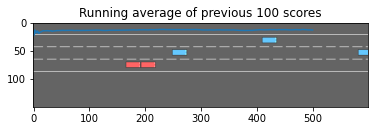

In [8]:
n_games = 500
figure_file = 'plots/highway_500'
torch.autograd.set_detect_anomaly(True)
# print(env.observation_space.shape)
agent = Agent(input_dims=env.observation_space.shape,
              env=env,
              n_actions=5,
              max_size=10000)

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

if load_checkpoint:
    agent.load_models()
    env.render(mode='human')
    
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        new_observation, reward, done, info = env.step(action)
        score += reward
        # print(f'observation.shape: {observation.shape}')
        agent.remember(observation, action, reward, new_observation, done)
        if not load_checkpoint:
            agent.learn()
        observation = new_observation
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    
    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()
    
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    print(f'Episode: {i}, Score {score}, Average Score: {avg_score}')
    
if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

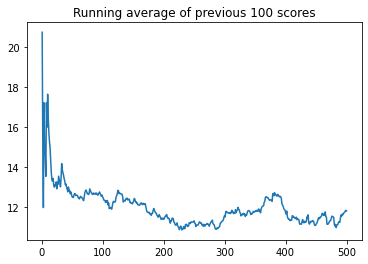

In [10]:
if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

In [9]:
env.close()
show_video()

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform(m.weight,  -3*1.e-4, 3*1.e-4)
            m.bias.data.fill_(0.0001)

class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        self.shared_layers = nn.Sequential( # todo: name
            nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=0),
            nn.Linear(64*12*12, 5),
        )
        self.shared_layers.apply(init_weights)

    def forward(self, x):
        input_tensor = torch.tensor(x, dtype=torch.float)
        hidden = self.shared_layers(input_tensor)
        #output = self.output(hidden)
        actions_probs = Categorical(F.softmax(hidden, dim=-1))

        return actions_probs, hidden

class CriticNet(nn.Module):
    def __init__(self):
        super(CriticNet, self).__init__()
        self.shared_layers = nn.Sequential(  # todo: name
            nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=0),
            nn.Linear(64 * 12 * 12, 1),
        )


    def forward(self, x):
        input_tensor = torch.FloatTensor(x)
        hidden = self.shared_layers(input_tensor)

        return hidden